CS573100 Music Information Retrieval

DDL: 2023.5.9.

Description: Homework 2. Intrument and pitch classification.

Requirements:
1. Name you file as HW2_{student-id}.ipynb and submit to eeclass.
2. Strongly recommend writing the report on your jupyter notebook file.

### 1. Explain meaning of TinySol1 dataset’s track ID annotation

**Track ID: Cb-ord-A2-ff-1c-R100d**
* The track ID follows the format (INSTR)-ord-(PITCH)-(DYN)-(INSTANCE)-(MISC) where
    * INSTR is the abbreviation of the instrument
    * ord is the abbreviation for ordinario (the ordinary playing technique)
    * PITCH denotes the pitch of the musical note
    * DYN denotes the intensity dynamics, ranged from pp to ff
    * INSTANCE denotes additional information about the instrument being played
        * For bowed instruments, 1c, 2c, 3c, 4c denotes which string is being bowed
        * For wind instruments, alt1, alt2, denotes alternative instances of the note if the same note is played multiple times
        * N for not applicable
    * MISC denotes additional info
        * R stands for resampled, denotes that it is obtained by transforming a different audio clip
        * T stands for tuned, Because some pitches are out of tune
        * N for natural, meaning the note is distributed as it was recorded
* So this example corresponds to 
    * a contrabass sound
    * played in the ordinary playing technique
    * at pitch A2
    * with fortissimo dynamics
    * on the first string
    * resampled from a A#2 by lowering pitch by a semitone, i.e. 100 cents (R100d)

### 2. Find audio file and plot

### 2.5 Data preperation

In [14]:
import librosa

# Load TinySOL metadata
# Import mirdata library
import mirdata

# Initialize tinysol dat

tinysol_dataset = mirdata.initialize("tinysol")
# tinysol_dataset.download()
# Load tinysol metadata
tinysol_metadata = tinysol_dataset._metadata

#### Feature Extraction

In [15]:
import numpy as np
# Create empty lists to store MFCC features and labels
mfccs_list = []
instrument_list = []
pitch_list = []

# Iterate through all the tracks in the dataset
for track_id in tinysol_dataset.track_ids:
  
  # Load a track by its ID
  track = tinysol_dataset.track(track_id)

  # Print some track information
  # print("----------------------")
  # print("Track ID:", track.track_id)
  # print("Instrument name:", track.instrument_full)
  # print("Pitch class:", track.pitch)
  #print("Dynamics:", track.dynamics)

  # Load and play the audio file of the track
  audio, sr = track.audio
  #track.play_audio()

  # TODO:  IMPLEMENT FEATURE EXTRACTION
  mfcc = librosa.feature.mfcc(y=audio, sr=sr)
  feat = np.average(mfcc, axis=1)
  # Append the MFCC features and labels to the lists
  mfccs_list.append(feat)
  instrument_list.append(track.instrument_full)
  pitch_list.append(track.pitch)

In [16]:
# Convert the lists to numpy arrays for tensorflow compatibility[^2^][2] [^3^][3]
mfccs_array = np.array(mfccs_list)
instrument_array = np.array(instrument_list)
pitch_array = np.array(pitch_list)

#### Encode labels

In [17]:
from sklearn import preprocessing

#### Split Training Set and Testing Set 

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train_instrument, y_test_instrument, y_train_pitch, y_test_pitch = train_test_split(
    mfccs_array, instrument_array, pitch_array,test_size=0.2, random_state=23) # DON'T Modify Random_state!


In [20]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [21]:
from sklearn import preprocessing

### 3. Instrument Classification

In [138]:
oh_encoder = preprocessing.OneHotEncoder()
oh_y_train_instrument = oh_encoder.fit_transform(y_train_instrument.reshape(-1, 1)).toarray()

In [139]:
from keras import layers

input_shape = (None, 20)
units = len(instr_classes)

inputs = layers.Input(shape=input_shape)
x = layers.Dense(10, activation="relu")(inputs)
x = layers.Dropout(rate=0.1)(x)
x = layers.Dense(10, activation="relu")(x)
outputs = layers.Dense(units, activation="relu")(x)
mlp = keras.Model(inputs, outputs)

mlp.compile(optimizer="adam", loss="categorical_crossentropy")
mlp.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, None, 20)]        0         
                                                                 
 dense_50 (Dense)            (None, None, 10)          210       
                                                                 
 dropout_1 (Dropout)         (None, None, 10)          0         
                                                                 
 dense_51 (Dense)            (None, None, 10)          110       
                                                                 
 dense_52 (Dense)            (None, None, 14)          154       
                                                                 
Total params: 474
Trainable params: 474
Non-trainable params: 0
_________________________________________________________________
73/73 [==============================] - 1s 2ms/step - loss: 

In [160]:
# Import scikit-learn library for SVM model and K-fold cross-validation
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold


# Create a model for Intstrument Classification
svm = SVC()
dt = DecisionTreeClassifier()

# Perform K-fold cross-validation 
kfold = KFold(n_splits=6)
for train_index, val_index in kfold.split(X_train):
  X_train_kfold, X_val_kfold = X_train[train_index], X_train[val_index]
  y_train_kfold_instrument, y_val_kfold_instrument = y_train_instrument[train_index], y_train_instrument[val_index]

  oh_y_train_kfold_instrument = oh_encoder.transform(y_train_kfold_instrument.reshape(-1,1)).toarray()

  # TODO: Train your model using the train subset
  svm.fit(X_train_kfold, y_train_kfold_instrument)
  dt.fit(X_train_kfold, y_train_kfold_instrument)
  mlp.fit(X_train_kfold, oh_y_train_kfold_instrument)

  # TODO:　Evaluate your model  using the validation subset
  svm_score = accuracy_score(y_val_kfold_instrument, svm.predict(X_val_kfold))
  dt_score = accuracy_score(y_val_kfold_instrument, dt.predict(X_val_kfold))

  predicts = oh_encoder.inverse_transform(mlp.predict(X_val_kfold)).reshape(1,-1)[0]
  mlp_score = accuracy_score(y_val_kfold_instrument, predicts)

  print("svm val score:", svm_score)
  print("dt val score:", dt_score)
  print("mlp val score:", mlp_score)

svm.fit(X_train, y_train_instrument)
dt.fit(X_train, y_train_instrument)

# TODO: Evaluate your model using the test set
svm_score = accuracy_score(y_test_instrument, svm.predict(X_test))

dt_score = accuracy_score(y_test_instrument, dt.predict(X_test))

# mlp
predicts = oh_encoder.inverse_transform(mlp.predict(X_test)).reshape(1,-1)[0]
mlp_score = accuracy_score(y_test_instrument, predicts)

print("-----------------")
print("svm test score:", svm_score)
print("dt test score:", dt_score)
print("mlp test sccore", mlp_score)

13/13 [==============================] - 0s 956us/step
svm val score: 0.6426735218508998
dt val score: 0.794344473007712
mlp val score: 0.38817480719794345
13/13 [==============================] - 0s 976us/step
svm val score: 0.5809768637532133
dt val score: 0.7840616966580977
mlp val score: 0.3496143958868895
13/13 [==============================] - 0s 1ms/step
svm val score: 0.6134020618556701
dt val score: 0.7963917525773195
mlp val score: 0.41237113402061853
13/13 [==============================] - 0s 1ms/step
svm val score: 0.6314432989690721
dt val score: 0.8144329896907216
mlp val score: 0.43041237113402064
13/13 [==============================] - 0s 1ms/step
svm val score: 0.595360824742268
dt val score: 0.8041237113402062
mlp val score: 0.41494845360824745
13/13 [==============================] - 0s 1ms/step
svm val score: 0.5902061855670103
dt val score: 0.7757731958762887
mlp val score: 0.41237113402061853
19/19 [==============================] - 0s 1ms/step
----------------

Confusion matrix


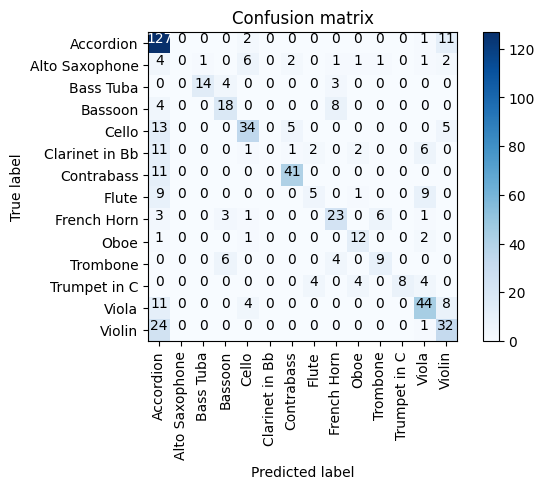

ACC =  0.63
precision =  0.63
recall =  0.63


In [ ]:
def evaluate(ground_truth, pred):
    accuracy = accuracy_score(ground_truth, pred)
    recall = recall_score(ground_truth, pred, average='micro') #can try other ave method
    precision = precision_score(ground_truth, pred, average='micro')
    cm = confusion_matrix(ground_truth, pred)
    plot_confusion_matrix(cm , instr_classes)
    print('ACC = ',  round(accuracy,3))
    print('precision = ', round(precision,3))
    print('recall = ', round(recall, 3))

y_pred_instr = model.predict(X_test)
evaluate(y_test_instrument, y_pred_instr)

### 4. Pitch Classification

In [ ]:
pitch_le = preprocessing.LabelEncoder()

pitch_array = pitch_le.fit_transform(pitch_array)
pitch_classes = pitch_le.classes_
print(pitch_classes)

In [ ]:
# Create a model for Pitch Classification
svm_pitch = SVC()
# Perform K-fold cross-validation 
kfold = KFold(n_splits=6)
for train_index, val_index in kfold.split(X_train):
  # Get the train and validation subsets
  X_train_kfold, X_val_kfold = X_train[train_index], X_train[val_index]
  y_train_kfold_pitch, y_val_kfold_pitch = y_train_pitch[train_index], y_train_pitch[val_index]

  # TODO: Train your model using the train subset
  svm_pitch.fit(X_train_kfold, y_train_kfold_pitch)

  # TODO:　Evaluate your model  using the validation subset
  score = accuracy_score(y_val_kfold_pitch, svm_pitch.predict(X_val_kfold))
  print("Validation score:", score)

# TODO: Evaluate the model on the instrument label using the test set

test_score = accuracy_score(y_test_pitch, model.predict(X_test))
print("Test score:", test_score)

Validation score: 0.06940874035989718
Validation score: 0.06683804627249357
Validation score: 0.09020618556701031
Validation score: 0.07989690721649484
Validation score: 0.07989690721649484
Validation score: 0.07989690721649484
Test score: 0.003430531732418525


Confusion matrix


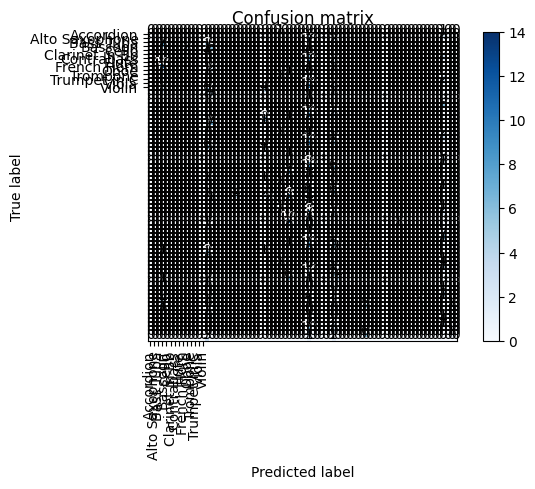

ACC =  0.074
precision =  0.074
recall =  0.074


In [ ]:
y_pred_pitch = svm_pitch.predict(X_test)
evaluate(y_test_pitch, y_pred_pitch)

In [ ]:
y_pred_pitch = svm_pitch.predict(X_test)

le = preprocessing.LabelEncoder()
le.fit(y_pred_pitch)

accuracy = accuracy_score(y_test_pitch, y_pred_pitch)
recall = recall_score(y_test_pitch, y_pred_pitch, average='micro') #can try other ave method
precision = precision_score(y_test_pitch, y_pred_pitch, average='micro')

print('ACC = ',  round(accuracy,3))
print('precision = ', precision)
print('recall = ', recall)

ACC =  0.074
precision =  0.07375643224699828
recall =  0.07375643224699828


### 5. Grid search to find best hyperparameters